Feature extraction and classification
=====================================

We extract various features from the audio files using essentia and we use these features as input for an [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) classifier. 

These features are related to the timbre

## Instalation of packages

To download, validate, and load the data we use the mirdata library.
We use MTG's [essentia](https://essentia.upf.edu) for audio loading and feature computation. Matplotlib's pyplot is used for plotting and pandas for data stats. 
We install these libraries through PyPI. 

In [1]:
%%capture
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install git+https://github.com/mir-dataset-loaders/mirdata.git
!pip install pandas
!pip install matplotlib

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd

# Temporary folder to write features to
import tempfile
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())



## Data processing
### Data downloading, validation

In [3]:
#Import Mridangam Stroke Dataset
mridangam_stroke = mirdata.initialize('mridangam_stroke')

#This cell downloads and validates the mridangam dataset
mridangam_stroke.download()  # download the dataset
mridangam_stroke.validate()  # validate that all the expected files are there

INFO: Downloading ['remote_data'] to /Volumes/storessd/Users/mariusmiron/mir_datasets/mridangam_stroke


INFO: [remote_data] downloading mridangam_stroke_1.5.zip


INFO: /Volumes/storessd/Users/mariusmiron/mir_datasets/mridangam_stroke/mridangam_stroke_1.5.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


  0%|          | 0/6976 [00:00<?, ?it/s]

  3%|▎         | 237/6976 [00:00<00:02, 2366.21it/s]

  8%|▊         | 527/6976 [00:00<00:02, 2678.10it/s]

 11%|█▏        | 795/6976 [00:00<00:02, 2653.17it/s]

 15%|█▌        | 1061/6976 [00:00<00:02, 2563.24it/s]

 19%|█▉        | 1350/6976 [00:00<00:02, 2672.72it/s]

 23%|██▎       | 1618/6976 [00:00<00:02, 2601.91it/s]

 28%|██▊       | 1939/6976 [00:00<00:01, 2792.25it/s]

 32%|███▏      | 2231/6976 [00:00<00:01, 2828.67it/s]

 36%|███▌      | 2515/6976 [00:00<00:01, 2718.14it/s]

 40%|████      | 2794/6976 [00:01<00:01, 2737.01it/s]

 46%|████▌     | 3179/6976 [00:01<00:01, 3066.90it/s]

 51%|█████     | 3554/6976 [00:01<00:01, 3262.74it/s]

 56%|█████▌    | 3882/6976 [00:01<00:00, 3228.11it/s]

 60%|██████    | 4206/6976 [00:01<00:00, 3029.03it/s]

 65%|██████▍   | 4512/6976 [00:01<00:00, 2764.59it/s]

 69%|██████▊   | 4795/6976 [00:01<00:00, 2313.27it/s]

 72%|███████▏  | 5055/6976 [00:01<00:00, 2380.87it/s]

 77%|███████▋  | 5343/6976 [00:01<00:00, 2506.65it/s]

 80%|████████  | 5604/6976 [00:02<00:00, 2495.87it/s]

 84%|████████▍ | 5878/6976 [00:02<00:00, 2561.97it/s]

 88%|████████▊ | 6140/6976 [00:02<00:00, 2436.08it/s]

 93%|█████████▎| 6468/6976 [00:02<00:00, 2667.41it/s]

 97%|█████████▋| 6765/6976 [00:02<00:00, 2752.26it/s]

100%|██████████| 6976/6976 [00:02<00:00, 2708.49it/s]


INFO: Success: the dataset is complete and all files are valid.


INFO: --------------------


({'tracks': {}}, {'tracks': {}})

In [4]:
mridangam_ids = mridangam_stroke.track_ids  # Load Mridangam IDs
mridangam_data = mridangam_stroke.load_tracks()  # Load Mridangam data

In [5]:
# Get complete list of different strokes
stroke_names = []
for i in mridangam_ids:
    stroke_names.append(mridangam_data[i].stroke_name)
stroke_names = np.unique(stroke_names)

In [6]:
# You can create a dictionary using stroke type as keys
stroke_dict = {item: [] for item in stroke_names}
for i in mridangam_ids:
    stroke_dict[mridangam_data[i].stroke_name].append(mridangam_data[i].audio_path)

## Feature extraction 

### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

In the downloaded dataset, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [7]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
# Raw-data preprocess analysis parameters
_, fs = mridangam_data[mridangam_ids[0]].audio
num_strokes = len(stroke_dict.keys())
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [8]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


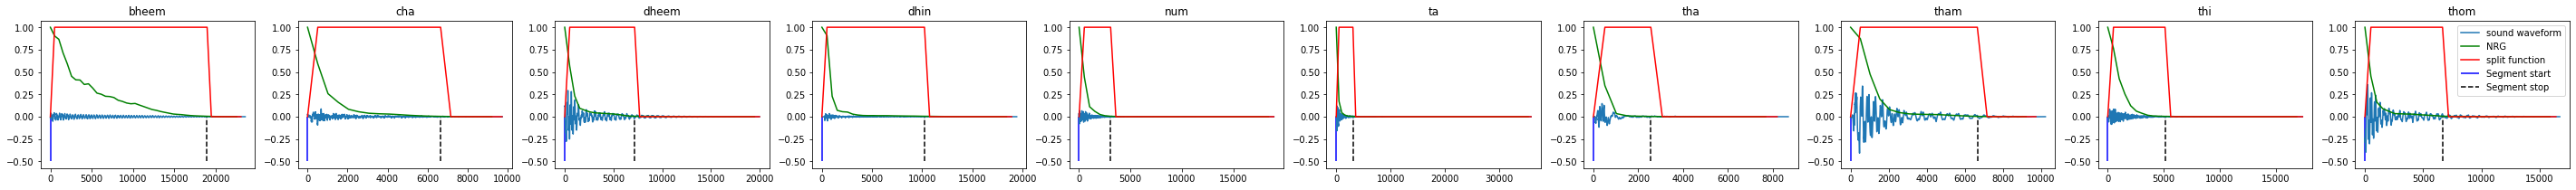

In [9]:
num_strokes = len(stroke_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_strokes, 3))
    for i, stroke in enumerate(stroke_dict.keys()):
        sample_file = stroke_dict[stroke][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_strokes,(i+1))
        plt.title(stroke)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [10]:
main_data_dir = tempdir
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for stroke, files in stroke_dict.items():
    for sample_file in files:
        #Get file id
        stroke_id =  sample_file.split('__')[-1].split('.')[0]
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            x_seg = x[start: stop]
            #Final check for amplitude (to avoid silent segments selection due to noise in split function)
            if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, stroke_id + '.wav')
                ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                segment_files.append(filename)

print(len(segment_files),'segment files created')

6854 segment files created


In [11]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)



Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [12]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(mridangam_data['224030'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [13]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(tempdir,'data.csv')
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in segment_files:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = filename.split('/')[-1].split('.')[0].split('-')[0]
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/bheem-dsh-014.wav


40 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/bheem-e-019.wav


60 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-b-015.wav


80 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-b-037.wav


100 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-c-002.wav


120 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-c-023.wav


140 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-c-045.wav


160 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-csh-022.wav


180 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-csh-052.wav


200 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-d-019.wav


220 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-d-040.wav


240 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-dsh-001.wav


260 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-dsh-021.wav


280 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-dsh-042.wav


300 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-e-013.wav


320 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-e-033.wav


340 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/cha-e-053.wav


360 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-b-022.wav


380 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-b-042.wav


400 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-b-062.wav


420 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-b-083.wav


440 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-b-112.wav


460 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-c-005.wav


480 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-c-025.wav


500 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-c-045.wav


520 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-c-065.wav


540 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-c-085.wav


560 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-csh-020.wav


580 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-csh-042.wav


600 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-csh-063.wav


620 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-d-006.wav


640 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-dsh-014.wav


660 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-dsh-034.wav


680 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-dsh-054.wav


700 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-dsh-075.wav


720 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-dsh-095.wav


740 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-e-004.wav


760 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-e-024.wav


780 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dheem-e-044.wav


800 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-b-013.wav


820 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-b-041.wav


840 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-c-026.wav


860 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-csh-053.wav


880 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-013.wav


900 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-033.wav


920 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-053.wav


940 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-074.wav


960 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-095.wav


980 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-115.wav


1000 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-135.wav


1020 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-155.wav


1040 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-175.wav


1060 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-dsh-195.wav


1080 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-e-017.wav


1100 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-e-037.wav


1120 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-e-057.wav


1140 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-e-077.wav


1160 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/dhin-e-097.wav


1180 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-b-004.wav


1200 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-b-024.wav


1220 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-b-048.wav


1240 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-b-073.wav


1260 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-c-012.wav


1280 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-c-032.wav


1300 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-c-052.wav


1320 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-c-073.wav


1340 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-c-095.wav


1360 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-csh-018.wav


1380 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-csh-038.wav


1400 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-csh-058.wav


1420 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-csh-081.wav


1440 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-d-004.wav


1460 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-006.wav


1480 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-026.wav


1500 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-046.wav


1520 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-066.wav


1540 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-086.wav


1560 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-106.wav


1580 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-dsh-126.wav


1600 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-e-003.wav


1620 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-e-023.wav


1640 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/num-e-044.wav


1660 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-004.wav


1680 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-024.wav


1700 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-044.wav


1720 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-064.wav


1740 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-084.wav


1760 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-104.wav


1780 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-124.wav


1800 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-b-144.wav


1820 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-019.wav


1840 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-039.wav


1860 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-059.wav


1880 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-079.wav


1900 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-099.wav


1920 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-119.wav


1940 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-139.wav


1960 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-c-159.wav


1980 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-014.wav


2000 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-035.wav


2020 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-056.wav


2040 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-076.wav


2060 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-096.wav


2080 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-116.wav


2100 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-137.wav


2120 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-157.wav


2140 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-178.wav


2160 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-csh-198.wav


2180 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-001.wav


2200 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-021.wav


2220 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-041.wav


2240 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-061.wav


2260 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-082.wav


2280 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-102.wav


2300 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-122.wav


2320 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-144.wav


2340 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-d-164.wav


2360 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-004.wav


2380 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-024.wav


2400 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-044.wav


2420 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-064.wav


2440 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-084.wav


2460 files processed, current file:  /var/folders/y_/ty3y7s254tv3x9dkvh7tkn0m0000gn/T/segments/ta-dsh-105.wav


KeyboardInterrupt: 

In [34]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke
0,0.990684,15.045286,1.854457,0.372195,0.078171,155.698410,116.191475,7.763121,2.870029,1.459613,1.988782,0.384449,0.035729,3.081390,23.001263,6.743838,0.259211,0.051726,18.463203,18.154703,3.524484,2.027169,14.154247,9.713717,3.785260,5.626436,-17.972549,0.0,-18.916914,2.906923,-23.871981,0.0,22.157772,2.388509,0.508498,0.089175,110.114670,49.826588,5.980231,1.438695,...,0.0,1.000000,0.000000,0.269231,0.443560,177.982590,79.151657,3.384615,3.991115,-5.029452e-09,6.021744e-09,0.019326,0.023204,0.000011,0.000035,0.016561,0.018647,0.000400,0.001060,0.008619,0.011005,5.166698,0.773860,0.031672,0.052147,28.880934,9.020713,0.003634,0.002377,184.688629,104.330238,4.505211,0.720354,3449997.75,2149743.75,0.623849,0.403493,0.008395,0.002812,bheem
1,0.990684,14.898280,2.280415,0.391228,0.083327,133.322479,80.732307,6.428464,1.788766,1.242456,2.026722,0.385100,0.022905,4.722807,24.075768,6.496977,0.277370,0.058520,29.212107,24.449263,4.452918,2.262118,10.936172,10.461652,4.415651,5.037334,-15.419962,0.0,-15.889473,2.056010,-22.573931,0.0,21.784616,2.784943,0.527868,0.094261,99.897247,43.619888,5.009456,1.415897,...,0.0,0.950000,0.217945,0.200000,0.400000,160.514008,44.933578,3.050000,3.338787,-7.063661e-09,7.256550e-09,0.027060,0.027833,0.000003,0.000006,0.024027,0.023854,0.000197,0.000440,0.011819,0.012786,4.916273,0.704710,0.040183,0.057602,35.628502,11.007059,0.004391,0.002669,170.112305,54.856857,5.026465,0.800214,3145255.50,2228094.00,0.763095,0.469566,0.006445,0.001386,bheem
2,0.990684,14.472402,2.531276,0.355560,0.088243,104.285133,69.695946,5.909654,2.103197,1.706020,2.225517,0.368965,0.042397,0.000000,21.715366,7.841555,0.253213,0.056765,18.648695,16.467173,3.559798,1.866340,13.307286,11.045646,5.321993,6.361315,-14.960384,0.0,-14.960384,0.000000,-23.710999,0.0,20.911642,3.709286,0.488403,0.096959,102.251648,60.140495,5.307984,1.535789,...,0.0,1.000000,0.000000,0.214286,0.410326,180.786880,69.366158,2.928571,2.939006,-7.304727e-09,6.862479e-09,0.028052,0.026443,0.000010,0.000027,0.022770,0.019730,0.000253,0.000508,0.013326,0.014265,5.363946,0.8394

INFO: NumExpr defaulting to 2 threads.


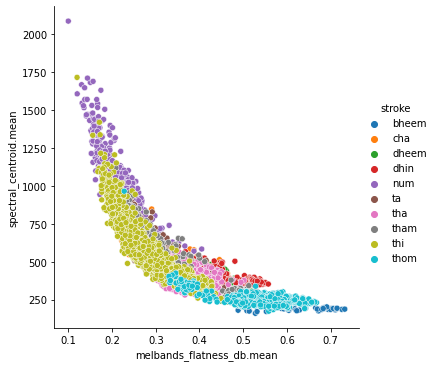

In [35]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "stroke", data = data);

### Preprocessing of the features


In [36]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [37]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.stroke.value_counts()

thi      2161
tha      1146
ta        921
thom      613
num       480
dheem     450
dhin      386
tham      357
cha       294
bheem      46
Name: stroke, dtype: int64

In [38]:
# Here we didn't pick the lowest number, 49 for bheem, which is too small. Instead, we choose the 330 of "cha"
min_number = data_modif.stroke.value_counts()['cha']
thi_data = data_modif[data_modif.stroke == 'thi'].sample(n = min_number, random_state = 42)
tha_data = data_modif[data_modif.stroke == 'tha'].sample(n = min_number)
ta_data = data_modif[data_modif.stroke == 'ta'].sample(n = min_number)
thom_data = data_modif[data_modif.stroke == 'thom'].sample(n = min_number)
num_data = data_modif[data_modif.stroke == 'num'].sample(n = min_number)
dhin_data = data_modif[data_modif.stroke == 'dhin'].sample(n = min_number)
dheem_data = data_modif[data_modif.stroke == 'dheem'].sample(n = min_number)
tham_data = data_modif[data_modif.stroke == 'tham'].sample(n = min_number)
cha_data = data_modif[data_modif.stroke == 'cha'].sample(n = min_number)
bheem_data = data_modif[data_modif.stroke == 'bheem']
#Merging after downsampling
data_modif = pd.concat([thi_data, tha_data, ta_data, thom_data, num_data, dhin_data, dheem_data, tham_data, cha_data, bheem_data])
#Checking the balance again
data_modif.stroke.value_counts()

tha      294
thi      294
tham     294
ta       294
dheem    294
dhin     294
num      294
cha      294
thom     294
bheem     46
Name: stroke, dtype: int64

In [39]:
## Training a classifier 

##Training a classifier


### Support Vector Machine

In [60]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.stroke = pd.Categorical(data_modif.stroke)  # convert to categorical data
y = np.array(data_modif.stroke.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.         0.16669803 0.19569333 0.19187305 0.21813181 0.00518465
 0.00277292 0.11074965 0.03389682 0.29261579 0.27711622 0.61019934
 0.44115533 0.         0.12703365 0.10249303 0.25651655 0.18245836
 0.00977359 0.00827198 0.19769223 0.12555338 0.43349396 0.10128644
 0.17647126 0.16102995 0.32257256 0.         0.32257256 0.
 0.27492107 0.         0.18542482 0.14019162 0.25002372 0.24852188
 0.03578908 0.04781622 0.32291146 0.21155403 0.30302373 0.31848565
 0.79855294 0.27264357 0.         0.         1.         0.
 0.51428571 0.97979593 0.22318307 0.27022523 0.45163884 0.45208968
 0.8046493  0.14947107 0.20459315 0.14316509 0.02326046 0.02293771
 0.00932192 0.0100157  0.16637874 0.19816178 0.23642542 0.23819592
 0.75758891 0.23539464 0.32227111 0.3883777  0.08524024 0.05418312
 0.28644568 0.31019266 0.25744742 0.10386354 0.20940889 0.11931316
 0.20104476 0.10217799 0.15530405 0.10404513 0.41846153 0.47426487]
Class of the first sample:  8


In [61]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (1803, 84) , Size of train output vector:  (1803,)
Size of test features matrix:  (889, 84) , Size of test output vector:  (889,)


In [62]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

###Neural Networks

In [63]:
from sklearn.preprocessing import StandardScaler

# Let's start by applying normalisation
scaler = StandardScaler().fit(X_train)
norm_x_train = scaler.transform(X_train)
scalertest = StandardScaler().fit(X_train)
norm_x_test = scalertest.transform(X_test)

In [64]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train shape = ", y_train_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train shape =  (1803, 10)
One-hot encoded y_test shape =  (889, 10)


In [65]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 10))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train.shape[1])

In [66]:
model.summary()  # Plot summary of the model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 84)                336       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                3400      
_________________________________________________________________
batch_normalization_4 (Batch (None, 40)                160       
_________________________________________________________________
activation_6 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20)               

In [67]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train, y_train_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

## Evaluation
To test the model we compare the predictions with the ground truth labels on the examples we set aside for the testing. To that extent, we compute the accuracy of the model on the test set. 

### Support Vector Machine

In [68]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,

In [69]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.9021372328458943


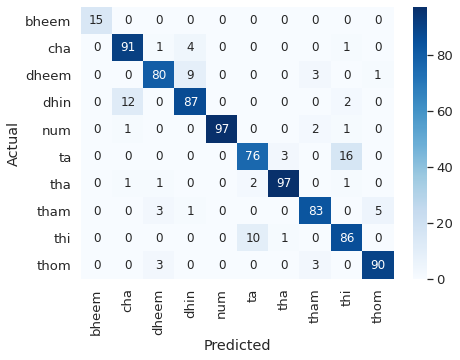

In [70]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.stroke)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

###Neural Networks

In [71]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.043769046664237976
Test accuracy: 0.9313835501670837


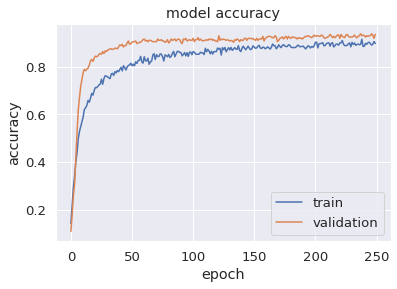

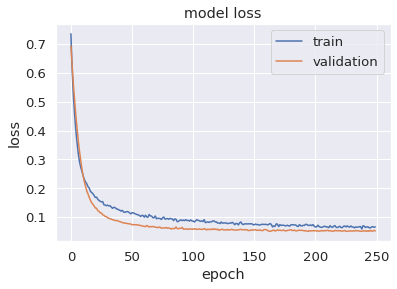

In [72]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()